<a href="https://colab.research.google.com/github/mowas455/NLP-kaggle-/blob/main/NLP_Disaster_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # Natural language Processing with Disaster Tweets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud ,STOPWORDS
from PIL import Image

## Dataset

Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

In [2]:
sample_submission = pd.read_csv("/content/sample_data/sample_submission.csv")
test = pd.read_csv("/content/sample_data/test.csv")
train = pd.read_csv("/content/sample_data/train.csv")

In [3]:
print(train.shape)
print(test.shape)

(7613, 5)
(3263, 4)


In [4]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
# To check the null values in the dataset
train.columns[train.isnull().any()]

Index(['keyword', 'location'], dtype='object')

In [6]:
# Estimate the target values 
train["target"].value_counts()

0    4342
1    3271
Name: target, dtype: int64

Text(0.5, 1.0, 'Comments of Twitter')

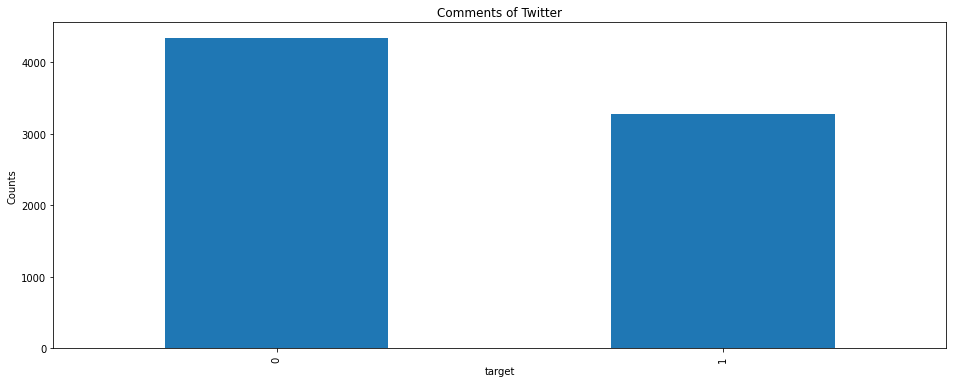

In [7]:
plt.figure(figsize=(16,6))
train["target"].value_counts().plot(kind="bar")
plt.xlabel("target")
plt.ylabel("Counts")
plt.title("Comments of Twitter")


### Preprocess the text

To implement preprocess we have to use spacy library to remove the remove the stop word, number, symbols and non-alphabetic letters


In [8]:
import spacy
import en_core_web_sm
nlp = spacy.load("en_core_web_sm")

In [9]:
# lower the words in training data
ltexts = [[word.lower() for word in line.split()] for line in train["text"]]

In [36]:
def preprocess(text):
    text = ' '.join(text)
    # tokenization and removing stop words
    token = [t for t in nlp(text) if not t.is_stop] 
    # lemmatization
    lemma = [lem.lemma_ for lem in token]
    # removing the non-alphabetic words
    return [' '.join(i for i in lemma if i.isalpha()) ]

In [37]:
print(ltexts[5])

# sample preprocessing for one text in the data
print(preprocess(ltexts[5]))

['#rockyfire', 'update', '=>', 'california', 'hwy.', '20', 'closed', 'in', 'both', 'directions', 'due', 'to', 'lake', 'county', 'fire', '-', '#cafire', '#wildfires']
['rockyfire update california hwy close direction lake county fire cafire wildfire']


In [38]:
proc_text = []
for i in range(len(ltexts)):
  proc_text.append(preprocess(ltexts[i])) 

In [39]:
print(proc_text[5])

['rockyfire update california hwy close direction lake county fire cafire wildfire']


### Naive Bayes Classifier


You are now ready to train and evaluate a classifier. More specifically, we ask you to train a Multinomial Naive Bayes classifier. You will have to

vectorize the speeches in the training data
instantiate and fit the Naive Bayes model
evaluate the model on the test data
The scikit-learn library provides a convenience class Pipeline that allows you to solve the first two tasks with very compact code. For the evaluation you can use the function classification_report, which will report per-class precision, recall and F1, as well as overall accuracy.

For the implementation of text classification.

vectorizer(countvectorizer)-- matrix document vector --- predictor(MNB)

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

In [15]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(train['text'],train['target'],test_size=0.3, random_state=9)
print(x_train.shape)
print(x_test.shape)

(5329,)
(2284,)


In [18]:
# pipeline the process of text classificatinn
pipe = Pipeline([("count_vectorizer",CountVectorizer()),
                 ("tfidf_transformer",TfidfTransformer()),
                 ("nb_classifier",MultinomialNB())])

# fit the model to the train data
pipe.fit(x_train, y_train)

# predict the train values 
train_pred = pipe.predict(x_train)
print(classification_report(y_train, train_pred))

# predict the test values
test_pred = pipe.predict(x_test)
print(classification_report(y_test, test_pred))

              precision    recall  f1-score   support

           0       0.85      0.98      0.91      3046
           1       0.97      0.77      0.86      2283

    accuracy                           0.89      5329
   macro avg       0.91      0.88      0.89      5329
weighted avg       0.90      0.89      0.89      5329

              precision    recall  f1-score   support

           0       0.77      0.93      0.84      1296
           1       0.88      0.63      0.73       988

    accuracy                           0.80      2284
   macro avg       0.82      0.78      0.79      2284
weighted avg       0.81      0.80      0.79      2284



## Creating a balanced data set

In [20]:
t = [0,1]
from sklearn.utils import resample

min_amount = min(train['target'].value_counts())
min_amount

# open a list to segragate a each class values
dflist=[]
for i in t:
   dflist.append(train[train["target"]==i])

# sampling function
def nsample(x, n=min_amount):
  new = resample(x, replace = False, n_samples = n)
  return new  

# Apppend the eqaully sampled data of each classes
undersampled_data  = []
for i in dflist:
  undersampled_data.append(nsample(i))

# Final undersampled data
df2 =  pd.concat(undersampled_data)


In [23]:
df2

,id,keyword,location,text,target
2682,3848,detonation,NaN,Ignition Knock (Detonation) Sensor-Senso Stand...,0
6020,8599,seismic,Third rock from the Sun,@hebrooon u better learn derivative of formula...,0
1709,2465,collided,San Francisco,Mind blown by @GlassAnimals slithering viscous...,0
4739,6738,lava,buffalo / madrid / granada,let's play the floor is lava but instead of ju...,0
1483,2138,catastrophe,"Stockholm, Sweden",I rated Catastrophe (2015) 8/10 #IMDb - hilar...,0
...,...,...,...,...,...
2755,3958,devastation,NaN,70 Years After Atomic Bombs Japan Still Strugg...,1
3924,5580,flood,New York,2pcs 18W CREE Led Work Light Offroad Lamp Car...,1
3126,4490,electrocuted,"Mumbai, Maharashtra",Watching a man electrocuted on the roof of #mu...,1
5885,8405,sandstorm,USA,Watch This Airport Get Swallowed Up By A Sands...,1


In [25]:
# split the training and test data
bX_train = df2["text"]
by_train = df2["target"]


# fit the model to the train data
pipe.fit(bX_train, by_train)

# predict the train values 
btrain_pred = pipe.predict(bX_train)
print(classification_report(by_train, btrain_pred))

# predict the test values
btest_pred = pipe.predict(x_test)
print(classification_report(y_test, btest_pred))

              precision    recall  f1-score   support

           0       0.86      0.95      0.91      3271
           1       0.95      0.85      0.90      3271

    accuracy                           0.90      6542
   macro avg       0.91      0.90      0.90      6542
weighted avg       0.91      0.90      0.90      6542

              precision    recall  f1-score   support

           0       0.89      0.92      0.91      1296
           1       0.89      0.86      0.87       988

    accuracy                           0.89      2284
   macro avg       0.89      0.89      0.89      2284
weighted avg       0.89      0.89      0.89      2284



### Confusion matrix

A confusion matrix is a specific table that is useful when analysing the performance of a classifier. In this table, both the rows and the columns correspond to classes, and each cell  (i,j)  states how many times a sample with gold-standard class  i  was predicted as belonging to class  j .

In [26]:
# Creation of confusion matrix in using sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix

In [27]:
cm = confusion_matrix(y_test,btest_pred)
cm

array([[1195,  101],
       [ 142,  846]])

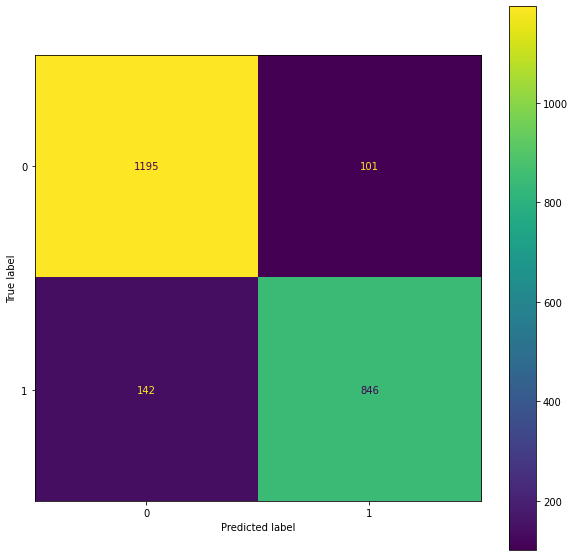

In [28]:
fig,ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=t)
disp.plot(ax=ax)
plt.show()

### Grid Search method to improve the accuracy

In [29]:
from sklearn.model_selection import GridSearchCV

In [30]:
Gpipe = Pipeline([('count_vect',CountVectorizer()),
                ('tfidf_transformer',TfidfTransformer()),
                ('nbClassifier',MultinomialNB())])


parameters = {
    'count_vect__binary': [True, False],
    'count_vect__ngram_range': [(1, 1), (1, 2)],
    'nbClassifier__alpha': (1, 0.1),
}

grid_search = GridSearchCV(Gpipe, parameters, cv=5)

In [31]:
# find the best parameters for both the feature extraction and the
 # classifier
clf = grid_search.fit(bX_train, by_train)
print(grid_search.best_params_)

{'count_vect__binary': True, 'count_vect__ngram_range': (1, 1), 'nbClassifier__alpha': 1}


In [34]:
cv_test_pred = clf.predict(x_test)
print(classification_report(y_test,cv_test_pred))

              precision    recall  f1-score   support

           0       0.89      0.92      0.91      1296
           1       0.89      0.86      0.88       988

    accuracy                           0.89      2284
   macro avg       0.89      0.89      0.89      2284
weighted avg       0.89      0.89      0.89      2284



###  Topic Modelling

In [35]:
import gensim
from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel

In [40]:
# Create a corpus from a list of texts
common_dictionary = Dictionary(proc_text)
corpus = [common_dictionary.doc2bow(text) for text in proc_text]

temp = common_dictionary[0]  # This is only to "load" the dictionary.
id2word = common_dictionary.id2token
# Train the model on the corpus.
model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    num_topics = 2 
)

In [41]:
model.print_topics()

[(0,
  '0.003*"wreckage conclusively confirm malaysia pm investigator family" + 0.002*"watch airport swallow sandstorm minute" + 0.002*"pic old pkk suicide bomber detonate bomb turkey army trench release" + 0.002*"rly tragedy mp live recount horror see coach train plunge water call" + 0.001*"family sue legionnaire family affect fatal outbreak legionnaire disea" + 0.001*"hot funtenna hijack computer send datum sound wave black hat prebreak good" + 0.001*"late home raze northern california wildfire abc news" + 0.001*"truth news bbc cnn islam truth god isis terrorism quran lie" + 0.001*"horrible sink feeling home phone realise g time" + 0.001*"refugio oil spill costlier big project"'),
 (1,
  '0.003*"wreckage conclusively confirm malaysia pm investigator family" + 0.002*"pic old pkk suicide bomber detonate bomb turkey army trench release" + 0.002*"watch airport swallow sandstorm minute" + 0.002*"rly tragedy mp live recount horror see coach train plunge water call" + 0.001*"family sue legi